In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [351]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
with open('data_users_topic_labeled.pickle', 'rb') as read_file:
    data_raw = pickle.load(read_file)

In [4]:
with open('user_comments_with_sentiment.pickle', 'rb') as read_file:
    data_raw_sentiment = pickle.load(read_file)


In [5]:
def process_raw_subreddit_counts(df_):
    df = df_.copy()
    for col in [
        'num_comments_political_discussion',
         'num_comments_democrats',
         'num_comments_warren',
         'num_comments_pete',
         'num_comments_biden',
         'num_comments_sanders',
         'num_comments_bloomberg',
         'num_comments_klob'
    ]:
        df[col.replace('num', 'perc')] = df[col] / df['num_comments']
    return df

In [6]:
def bucket_sentiment(sentiments):
    results = [0, 0, 0]
    for s in sentiments:
        if s <= -0.05:
            results[0] += 1
        elif s < 0.05:
            results[1] += 1
        else:
            results[2] += 1
    return tuple(results)

def process_raw_sentiment_scores(df_):
    df = df_.copy()
    df['sent_tuples'] = df.text_sentiment.map(bucket_sentiment)
    df['num_neg_sent_comments'] = df.sent_tuples.map(lambda x: x[0])
    df['num_neu_sent_comments'] = df.sent_tuples.map(lambda x: x[1])
    df['num_pos_sent_comments'] = df.sent_tuples.map(lambda x: x[2])
    df['perc_neg_sent_comments'] = df['num_neg_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    df['perc_neu_sent_comments'] = df['num_neu_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    df['perc_pos_sent_comments'] = df['num_pos_sent_comments'] / (df['num_neg_sent_comments'] + df['num_neu_sent_comments'] + df['num_pos_sent_comments'])
    return df.drop('sent_tuples', axis=1)

In [7]:
data_sent = process_raw_sentiment_scores(data_raw)
data_sub_dist = process_raw_subreddit_counts(data_sent)

In [8]:
with open('raw_tone_results.pickle', 'rb') as read_file:
    raw_tone = pickle.load(read_file)

In [9]:
tone_series = raw_tone.reset_index()

In [10]:
data_sub_dist['raw_tone'] = tone_series.drop('index', axis=1)

# Process Raw Tone Data

In [13]:
# remove tone errors
data_complete = data_sub_dist[data_sub_dist.raw_tone.map(lambda x: list(x.keys())[0]) != 'error']

In [14]:
from functools import reduce

def process_doc_tone(acc, next_tone):
    acc[next_tone['tone_id']] = next_tone['score']
    return acc

def process_raw_tone_overall(raw_tone_result):
    return reduce(process_doc_tone, raw_tone_result['document_tone']['tones'], {})

In [15]:
all_comment_tones = pd.DataFrame.from_records(data_complete.raw_tone.map(process_raw_tone_overall).values)
all_comment_tones.columns = ['all_comments_' + x for x in all_comment_tones.columns]

In [16]:
data_all_comm_proc = pd.concat([data_complete, all_comment_tones], axis=1)

In [17]:
from collections import Counter

def process_raw_tone_sentences(raw_tone_result):
    try:
        nested = [x['tones'] for x in raw_tone_result['sentences_tone']]
        flattened = [x['tone_id'] for sublist in nested for x in sublist]
        tone_counts = Counter(flattened)
        return {k: v / len(flattened) for k, v in tone_counts.items()}
    except:
        return {}

In [18]:
data_filtered_again = data_all_comm_proc[~data_all_comm_proc.raw_tone.isnull()]

In [19]:
sent_tone_percs = pd.DataFrame.from_records(data_filtered_again.raw_tone.map(process_raw_tone_sentences).values)
sent_tone_percs.columns = ['perc_comments_' + x for x in sent_tone_percs.columns]

In [20]:
data_everything = pd.concat([data_filtered_again, sent_tone_percs], axis=1)

# Handle Nulls and Filter

In [246]:
data_no_nulls = data_everything.replace(np.nan, 0)

In [247]:
columns_to_dummy = [
 'all_comments_joy',
 'all_comments_sadness',
 'all_comments_tentative',
 'all_comments_analytical',
 'all_comments_anger',
 'all_comments_fear',
 'all_comments_confident',
]

In [248]:
for col in columns_to_dummy:
    data_no_nulls[col] = data_no_nulls[col].map(lambda x: 1 if x > 0 else 0)

In [249]:
col_to_perc = [
    '2016_election_frustration',
    'impeachment_proceedings',
    'healthcare',
    'primary_candidates',
    'gun_control',
    'election_general_terms',
    'right_wing_media',
    'impeachment',
    'yang_ubi',
    'primary_debates',
    'bloomberg',
    'econ_trump_vs_obama',
    'race_identity',
    'tax_return_ukraine_biden',
    'election_midwest_swing',
    'monetary_policy',
    'rep_dem_comparison',
    'miltary_and_immigration',
]

In [250]:
data_cp = data_no_nulls.copy()
for c in col_to_perc:
    data_cp[c] = data_cp[c] / np.sum(data_no_nulls[col_to_perc], axis=1)

In [251]:
data_cp['avg_comment_score'] = data_cp.total_comment_score / data_cp.num_comments
data_cp['perc_neg_score_comments'] = data_cp.number_neg_score_comments / data_cp.num_comments

In [252]:
model_data = data_cp

In [253]:
model_data_final = model_data[model_data.num_comments > 0]

In [254]:
with open('clustering_data.pickle', 'wb') as write_file:
    pickle.dump(model_data_final, write_file)

# Clustering

In [255]:
no_outliers = model_data_final[model_data_final.num_comments < 600]
no_outliers = no_outliers[no_outliers.avg_comment_length < 1000]
no_outliers = no_outliers[no_outliers.perc_pos_sent_comments < 0.8]
no_outliers = no_outliers[no_outliers.avg_comment_score < 5]

## EDA

In [296]:
tone_global_fields = ['all_comments_joy', 'all_comments_sadness', 'all_comments_tentative',
                      'all_comments_analytical', 'all_comments_anger', 'all_comments_fear', 'all_comments_confident']
tone_sent_fields = [
    'perc_comments_analytical',
    'perc_comments_joy',
    'perc_comments_tentative',
    'perc_comments_sadness',
    'perc_comments_anger',
    'perc_comments_confident',
    'perc_comments_fear',
    'avg_comment_score',
    'perc_neg_score_comments'
]

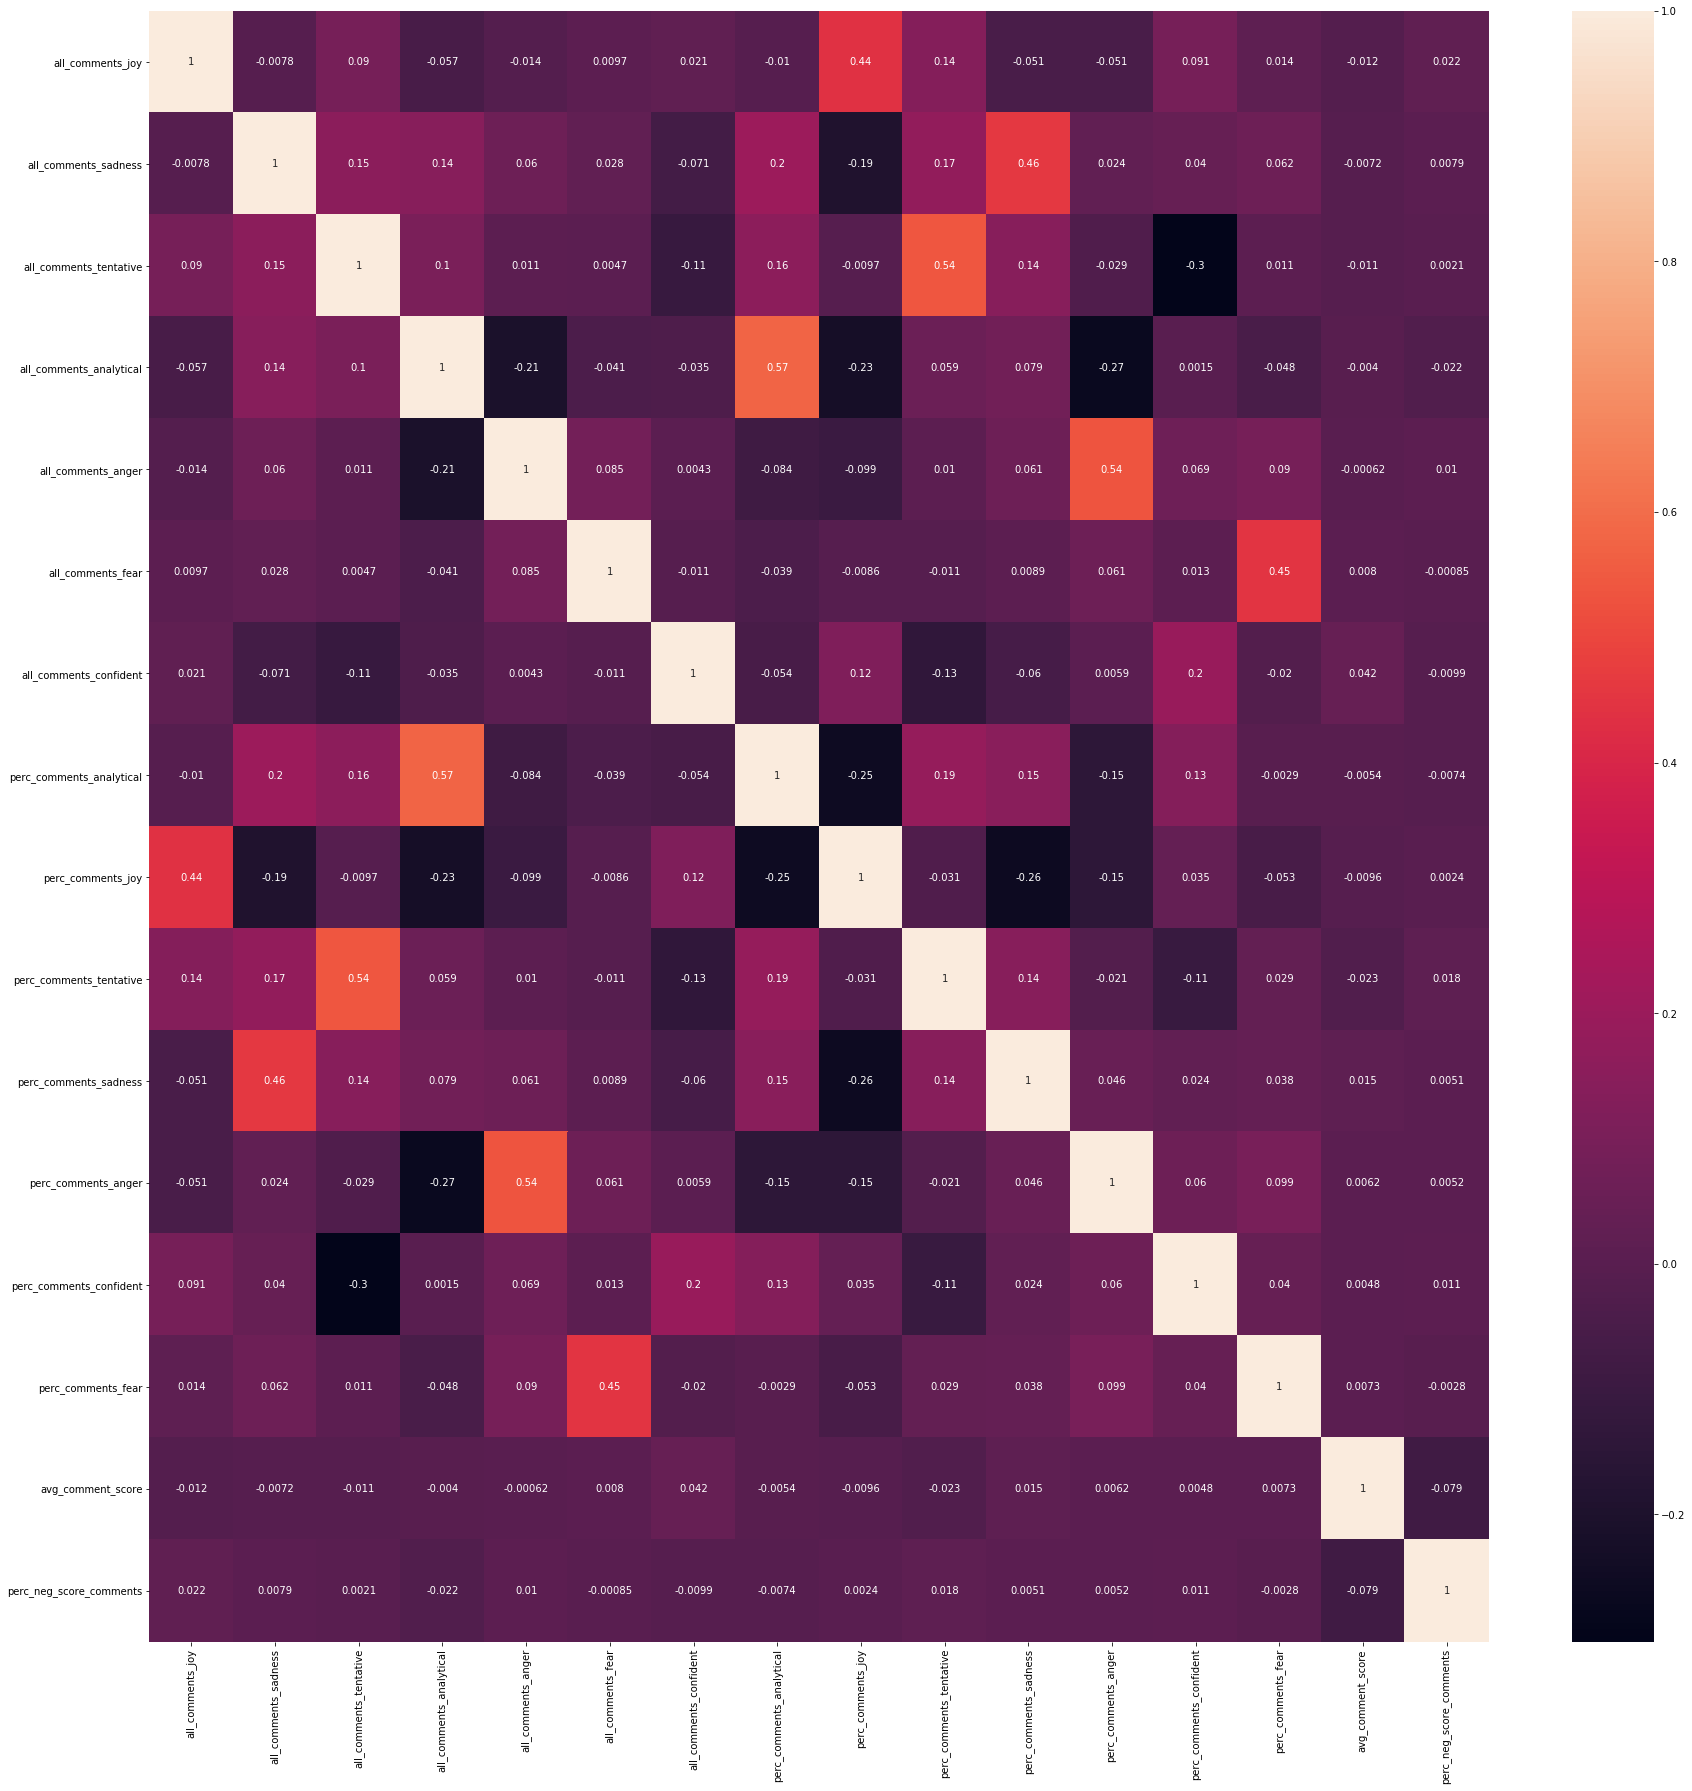

In [297]:
plt.figure(figsize=(30, 30))
sns.heatmap(no_outliers[tone_global_fields + tone_sent_fields].corr(), annot=True)

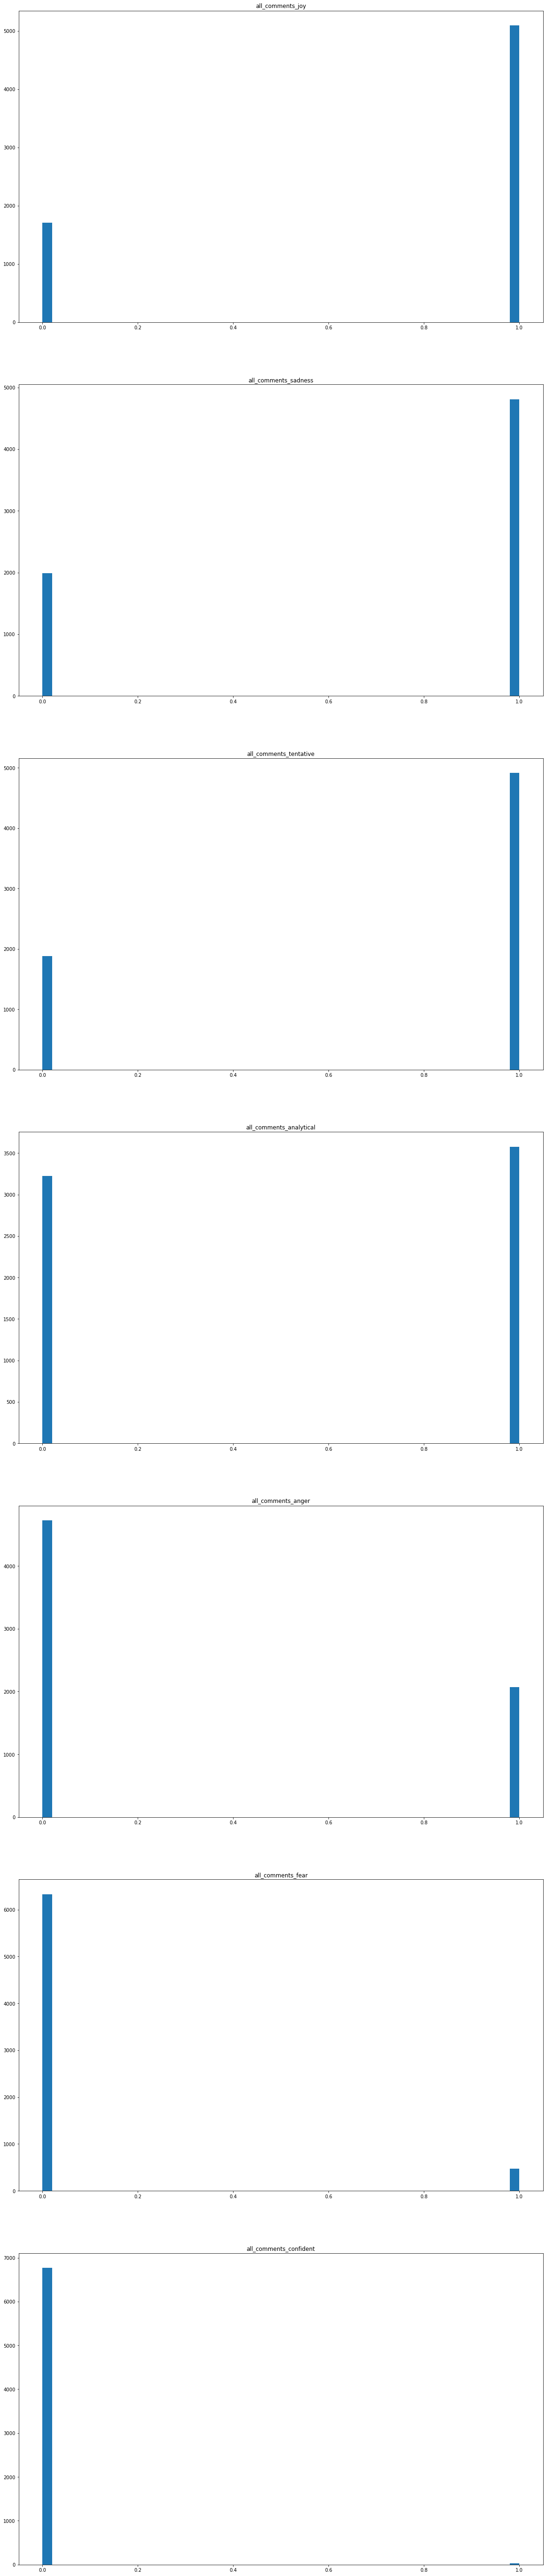

In [286]:
# hist_cols = [x for x in no_outliers.columns if x != 'text' and x != 'author']
hist_cols = tone_global_fields
num_hist = len(hist_cols)

plt.figure(figsize=(20, 100))

for i, col in enumerate(hist_cols):
    plt.subplot(num_hist, 1, i+1)
    plt.hist(no_outliers[col], bins=50)
    plt.title(col)
    

In [295]:
# how many people have at least one sad/joy - 11/12
# how many users have both sad/joy - 1/2
# how many users are both tentative and confident - 0 users
# how many users are both angry and analytical - 1/10
no_outliers[(no_outliers.all_comments_analytical == 1) & (no_outliers.all_comments_anger == 1)].shape


(764, 73)

## Dimensionality Reduction

### By Topic

In [256]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler

In [663]:
cluster_data = no_outliers.copy()

selected_columns = [
    #     '2016_election_frustration',
    #     'impeachment_proceedings',
    'impeachment',
    'healthcare',
#     'gun_control',
#     'primary_candidates',
    'primary_debates',
    'race_identity',
    #     'election_general_terms',
    'right_wing_media',
    #     'yang_ubi',
    #     'bloomberg',
    #     'econ_trump_vs_obama',
    #     'tax_return_ukraine_biden',
#     'election_midwest_swing',
    #     'monetary_policy',
    #     'rep_dem_comparison',
    #     'miltary_and_immigration',
#     'num_comments',
#     'avg_comment_length',
        'perc_neg_sent_comments',
    #     'perc_neu_sent_comments',
#         'perc_pos_sent_comments',
    #         'perc_comments_analytical',
    #         'perc_comments_joy',
    #         'perc_comments_tentative',
    #         'perc_comments_sadness',
    #         'perc_comments_anger',
    #         'perc_comments_confident',
    #         'perc_comments_fear',
    #     'avg_comment_score',
    #     'perc_neg_score_comments'
    #     'all_comments_joy',
#     'all_comments_sadness',
    #     'all_comments_tentative',
#     'all_comments_analytical',
#     'all_comments_anger',
#     'all_comments_fear',
    #     'all_comments_confident',
]

cluster_data = cluster_data[selected_columns]
# cluster_data['num_comments'] = np.log(cluster_data['num_comments'])
# cluster_data['avg_comment_length'] = np.log(cluster_data['avg_comment_length'])

In [680]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
data_std = scaler.fit_transform(cluster_data)

pca = PCA(random_state=99)
pca_res = pca.fit_transform(data_std)

pca_df = pd.DataFrame(pca_res)
cluster_df = pd.DataFrame(data_std, columns=selected_columns)

### PCA Exploration

In [681]:
np.sum(pca.explained_variance_ratio_[0:2])

0.5673410908175427

In [682]:
np.sum(pca.explained_variance_ratio_[0:3])

0.7318508245271399

In [683]:
pd.DataFrame(pca.components_[0:3], columns=selected_columns)

,impeachment,healthcare,primary_debates,race_identity,right_wing_media,perc_neg_sent_comments
0,-0.086,0.004,-0.314,-0.038,0.936,0.126
1,0.313,0.064,-0.470,-0.064,-0.237,0.785
2,0.023,-0.264,0.742,0.240,0.191,0.534


In [684]:
pca_labels = [
    'Negativity/Impeachment <-> Primary Debates',
    'Healthcare <-> Primary Debates/Negativity',
    'Impeachment/Primary Debates <->Race',
]

Text(0, 0.5, 'Healthcare <-> Primary Debates/Negativity')

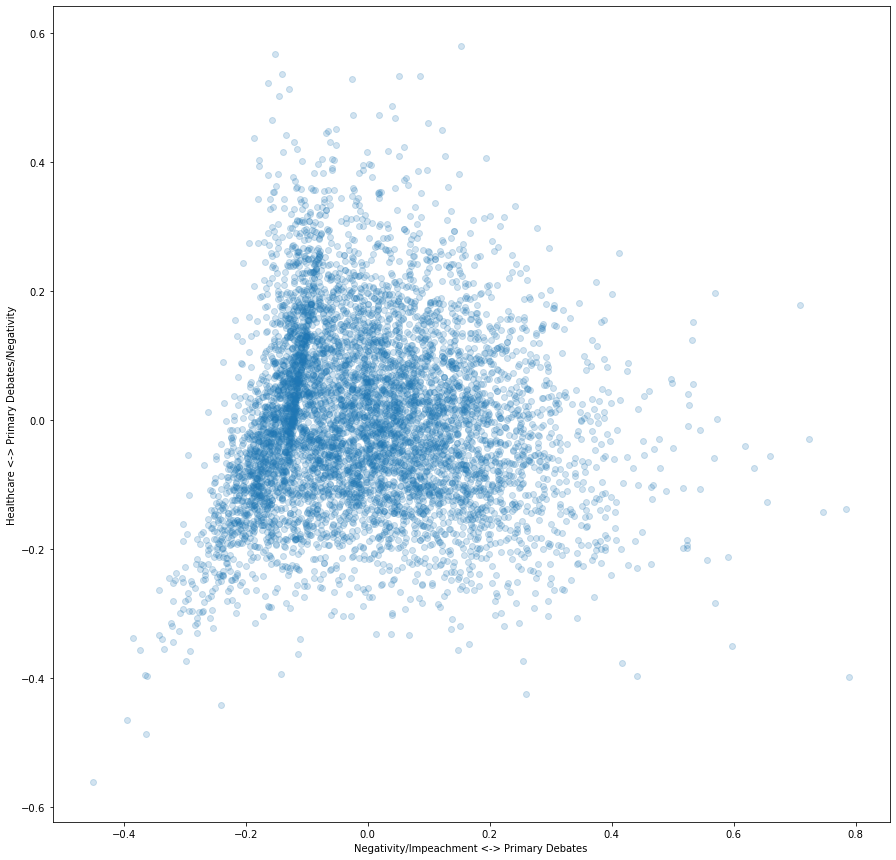

In [685]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[0], pca_df[1], alpha=0.2)
plt.xlabel(pca_labels[0])
plt.ylabel(pca_labels[1])

Text(0, 0.5, 'Impeachment/Primary Debates <->Race')

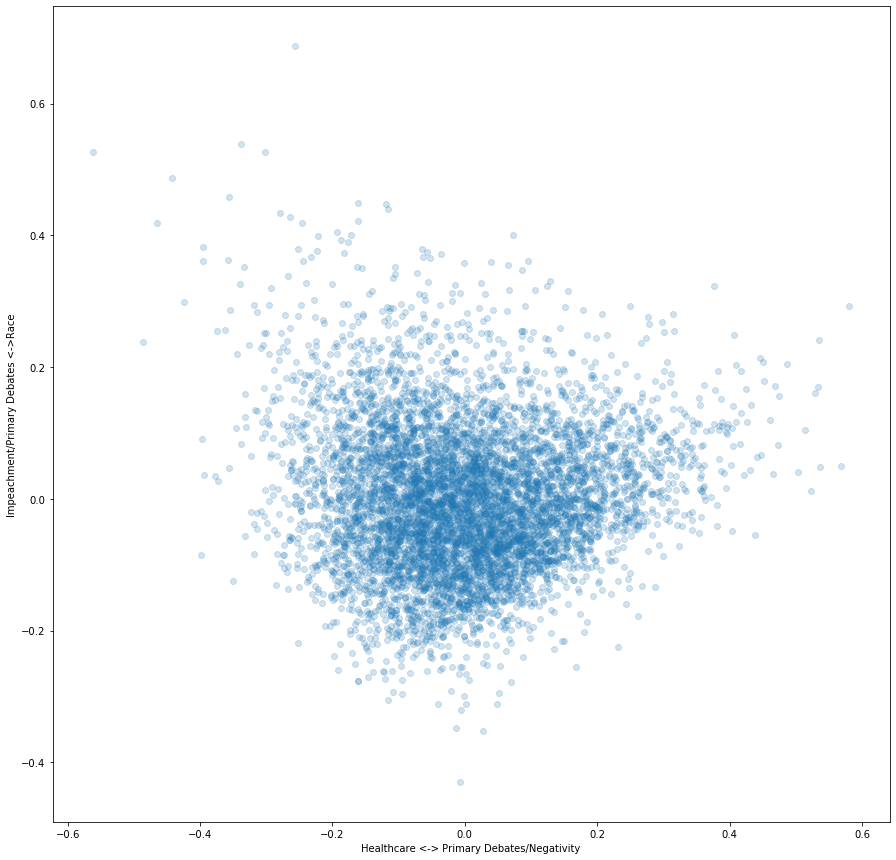

In [686]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[1], pca_df[2], alpha=0.2)
plt.xlabel(pca_labels[1])
plt.ylabel(pca_labels[2])

Text(0, 0.5, 'Impeachment/Primary Debates <->Race')

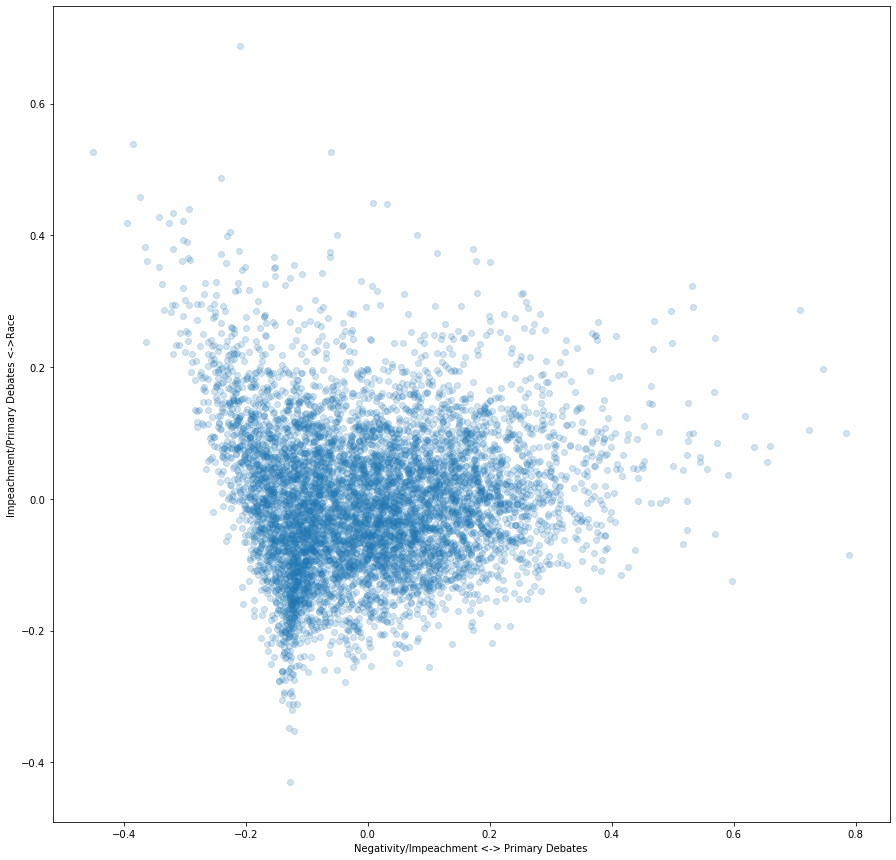

In [687]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[0], pca_df[2], alpha=0.2)
plt.xlabel(pca_labels[0])
plt.ylabel(pca_labels[2])

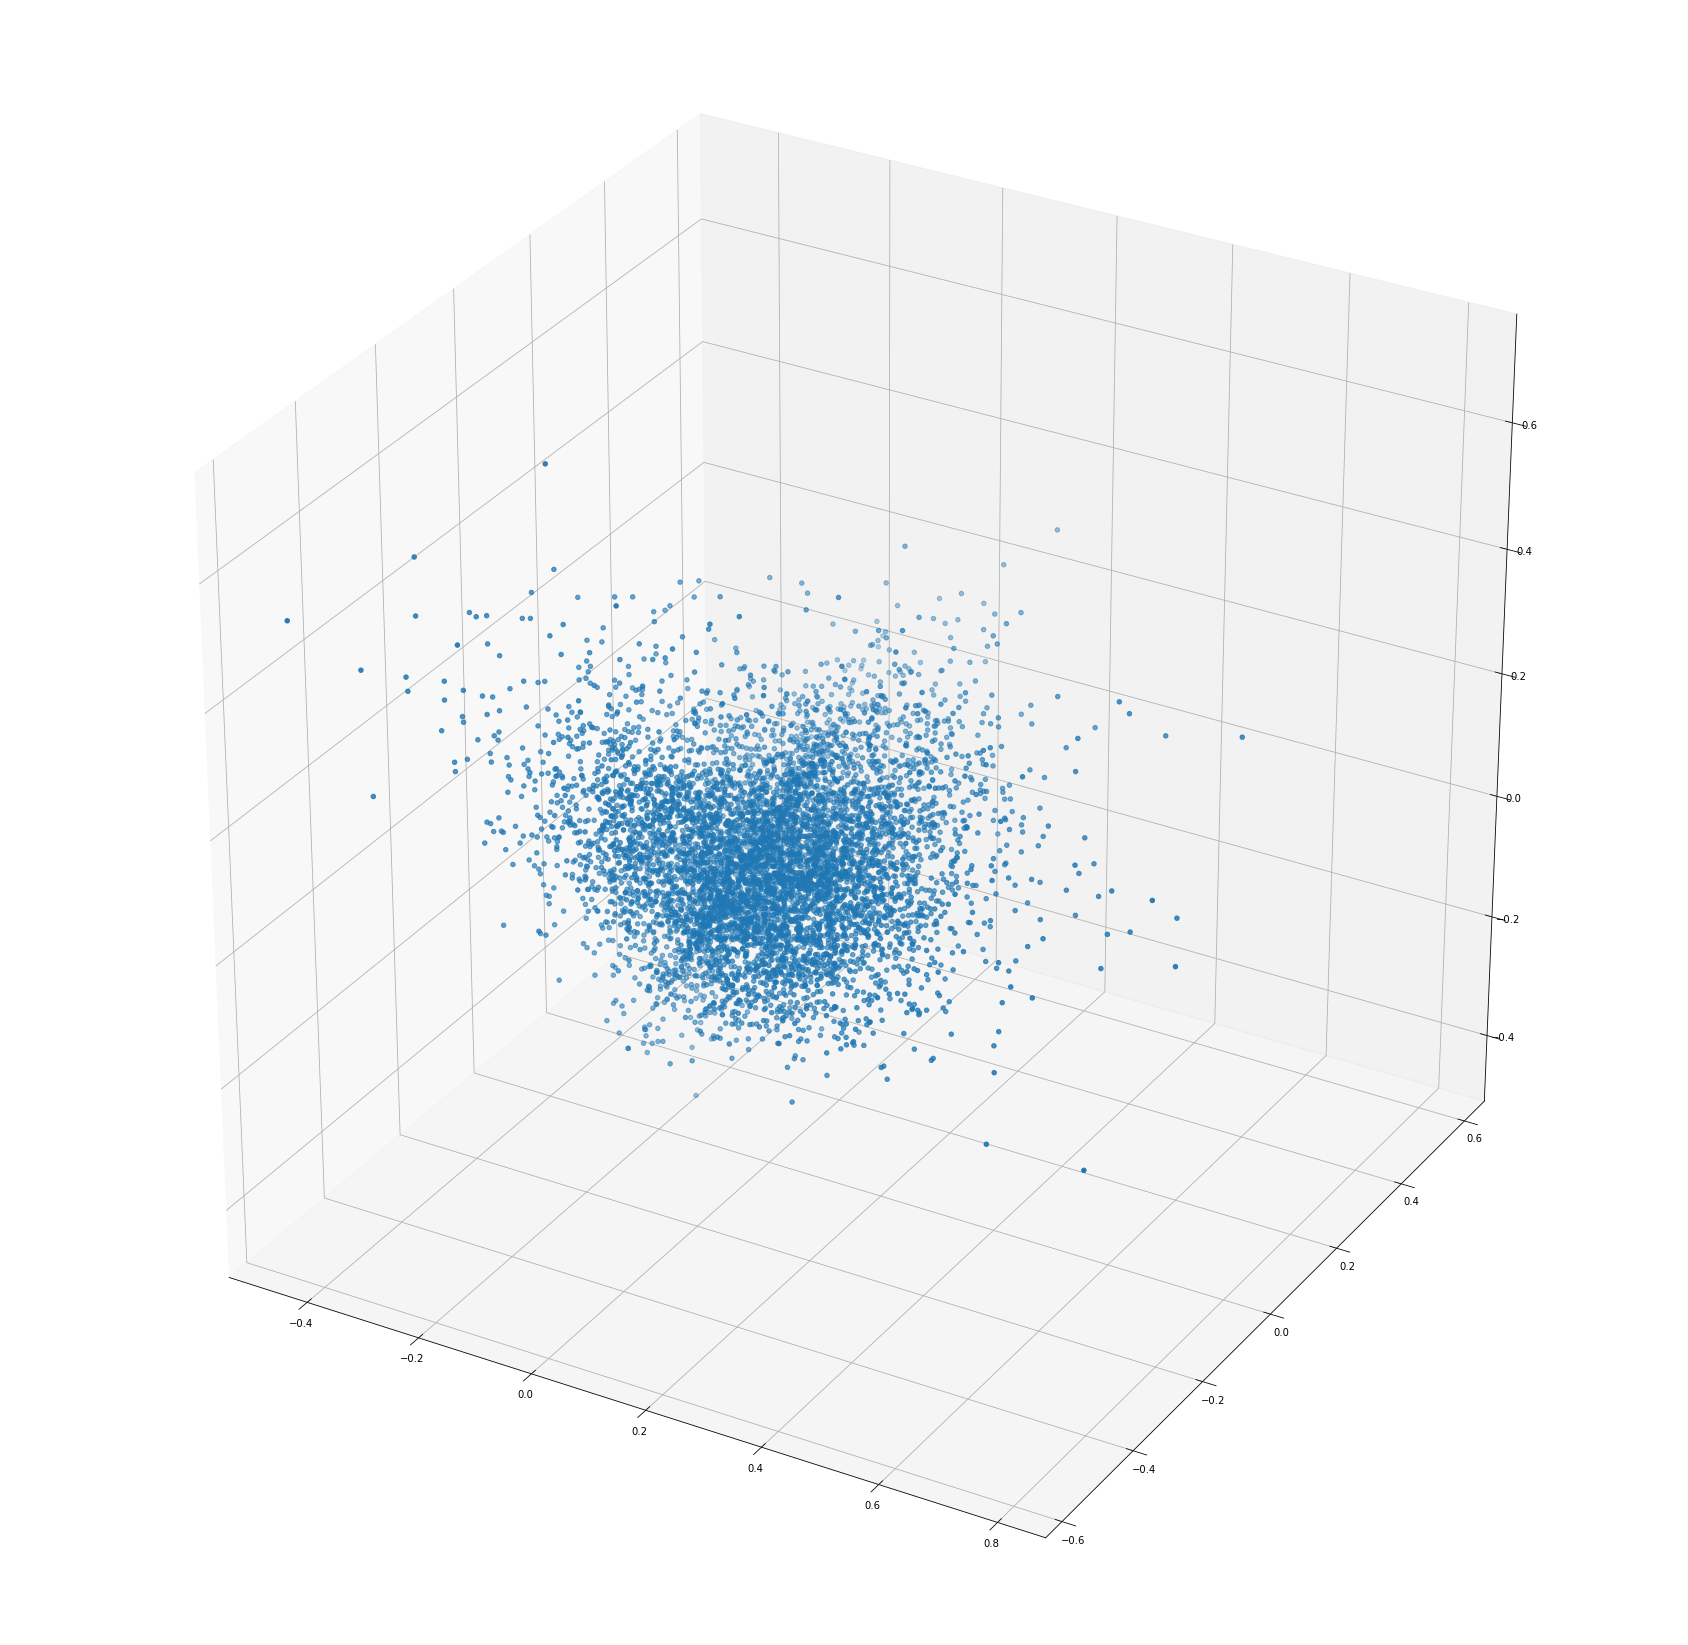

In [688]:
%matplotlib inline

plt.figure(figsize=(30, 30))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_df[0], pca_df[1], pca_df[2]);

### By Tone

In [474]:
model_data_final.columns

Index(['2016_election_frustration', 'impeachment_proceedings', 'healthcare',
       'primary_candidates', 'gun_control', 'election_general_terms',
       'right_wing_media', 'impeachment', 'yang_ubi', 'primary_debates',
       'bloomberg', 'econ_trump_vs_obama', 'race_identity',
       'tax_return_ukraine_biden', 'election_midwest_swing', 'monetary_policy',
       'rep_dem_comparison', 'miltary_and_immigration', 'index',
       'num_comments', 'total_comment_length', 'text', 'total_comment_score',
       'best_comment_score', 'worst_comment_score',
       'number_neg_score_comments', 'number_pos_score_comments',
       'total_neg_score', 'total_pos_score', 'num_comments_politics',
       'num_comments_political_discussion', 'num_comments_democrats',
       'num_comments_warren', 'num_comments_pete', 'num_comments_biden',
       'num_comments_sanders', 'num_comments_bloomberg', 'num_comments_klob',
       'author', 'avg_comment_length', 'text_sentiment', 'primary_topic_num',
       'num

In [ ]:
cluster_data = no_outliers.copy()

selected_columns = [
#     '2016_election_frustration', 
#     'impeachment_proceedings', 
#     'impeachment', 
#     'healthcare', 
#     'gun_control', 
#     'primary_candidates',
#     'primary_debates',
#     'race_identity',
#     'election_general_terms',
#     'right_wing_media', 
#     'yang_ubi', 
#     'bloomberg', 
#     'econ_trump_vs_obama', 
#     'tax_return_ukraine_biden', 
#     'election_midwest_swing', 
#     'monetary_policy',
#     'rep_dem_comparison', 
#     'miltary_and_immigration', 
#     'num_comments',
#     'avg_comment_length', 
    'perc_neg_sent_comments',
#     'perc_neu_sent_comments', 
#     'perc_pos_sent_comments',
    'perc_comments_analytical', 
    'perc_comments_joy',
    'perc_comments_tentative', 
    'perc_comments_sadness',
    'perc_comments_anger', 
    'perc_comments_confident', 
    'perc_comments_fear',
    'avg_comment_score', 
#     'perc_neg_score_comments'
]

cluster_data = cluster_data[selected_columns]
# cluster_data['num_comments'] = np.log(cluster_data['num_comments'])
# cluster_data['avg_comment_length'] = np.log(cluster_data['avg_comment_length'])

In [ ]:
scaler = StandardScaler()
data_std = scaler.fit_transform(cluster_data)

In [ ]:
pca = PCA()
pca_res = pca.fit_transform(data_std)

In [ ]:
pca_df = pd.DataFrame(pca_res)

In [ ]:
np.sum(pca.explained_variance_ratio_[0:2])

In [ ]:
np.sum(pca.explained_variance_ratio_[0:3])

In [ ]:
pd.DataFrame(pca.components_, columns=selected_columns)

In [ ]:
pca_labels = [
    'Neg Impeachment',
    'Pos Healthcare',
    'Neg Race',
    'Neg Debate'
]

# pca_labels = [
#     'Few/Long Comments',
#     'People Dont Like',
#     'Neg Race',
#     'Neg Debate'
# ]

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[0], pca_df[1], alpha=0.2)
plt.xlabel(pca_labels[0])
plt.ylabel(pca_labels[1])

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[1], pca_df[2], alpha=0.2)
plt.xlabel(pca_labels[1])
plt.ylabel(pca_labels[2])

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(pca_df[0], pca_df[2], alpha=0.2)
plt.xlabel(pca_labels[0])
plt.ylabel(pca_labels[2])

In [ ]:
%matplotlib inline

plt.figure(figsize=(30, 30))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_df[0], pca_df[1], pca_df[2]);

## Clustering

In [689]:
import pickle
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns

### K-Means

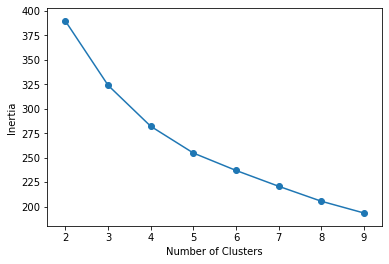

In [690]:
inertia = []
sil_scores = []
list_num_clusters = list(range(2,10))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=42)
    preds = km.fit_predict(cluster_df)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(cluster_df, preds))
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

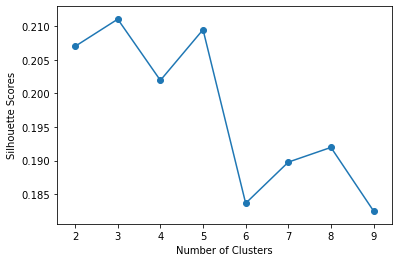

In [691]:
plt.plot(list_num_clusters,sil_scores)
plt.scatter(list_num_clusters,sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores');

In [ ]:
# 4 - 6 clusters according to the data

In [692]:
num_clusters = 4

In [694]:
km = KMeans(n_clusters=num_clusters, random_state=42)
preds = km.fit_predict(cluster_df)
preds_df = pd.DataFrame(preds, columns=['group'])
to_graph = pd.concat([cluster_df, preds_df], axis=1)
pca_graph = pd.concat([pca_df, preds_df], axis=1)
pd.DataFrame(scaler.fit_transform(km.cluster_centers_), columns=selected_columns)

,impeachment,healthcare,primary_debates,race_identity,right_wing_media,perc_neg_sent_comments
0,0.042,1.000,0.034,0.000,0.075,0.014
1,0.038,0.000,1.000,1.000,0.000,0.000
2,1.000,0.330,0.000,0.341,0.123,1.000
3,0.000,0.338,0.145,0.262,1.000,0.198


### Graph Clusters

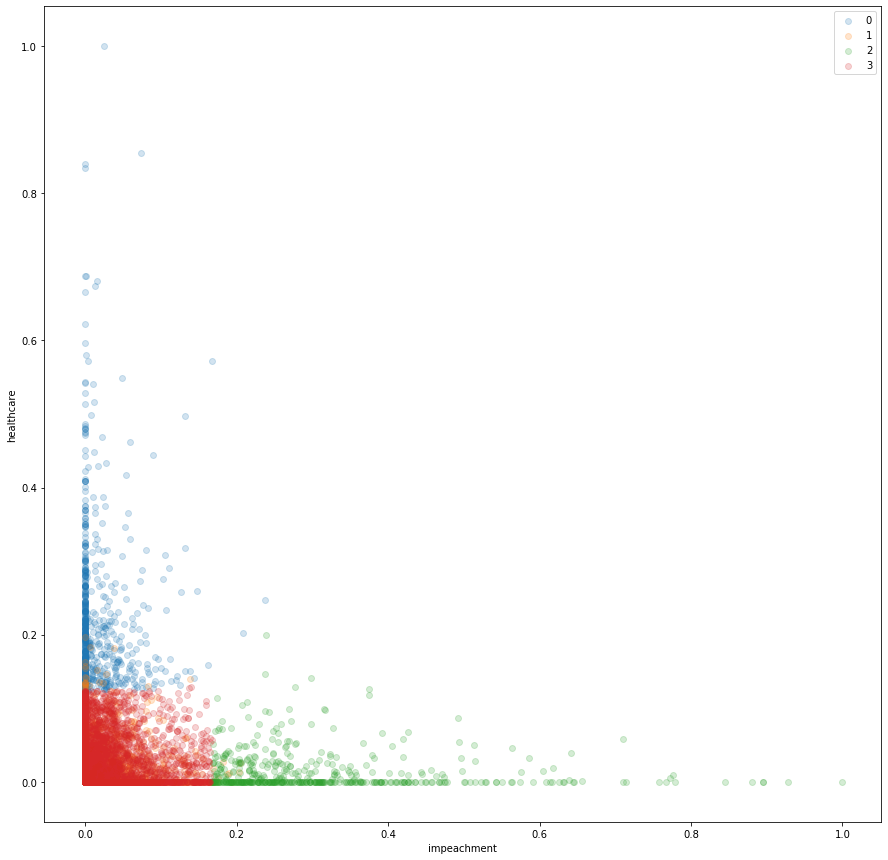

In [543]:
plt.figure(figsize=(15, 15))
for g in range(num_clusters):
    plt.scatter(
        pac[to_graph.group == g][to_graph.columns[0]],
        to_graph[to_graph.group == g][to_graph.columns[1]],
        alpha=0.2
    )
    plt.xlabel(to_graph.columns[0])
    plt.ylabel(to_graph.columns[1])
plt.legend(range(num_clusters))

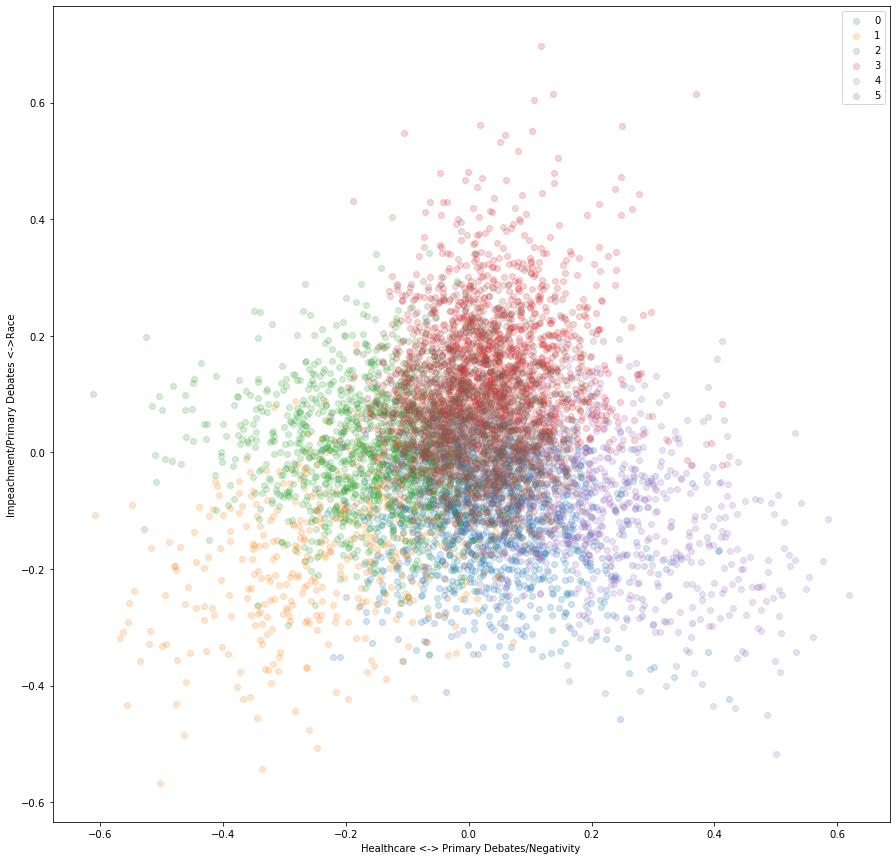

In [483]:
plt.figure(figsize=(15, 15))
for g in range(num_clusters):
    plt.scatter(to_graph[to_graph.group == g][1], to_graph[to_graph.group == g][2], alpha=0.2)
plt.xlabel(pca_labels[1])
plt.ylabel(pca_labels[2])
plt.legend(range(num_clusters))

Text(0, 0.5, 'Impeachment/Primary Debates <->Race')

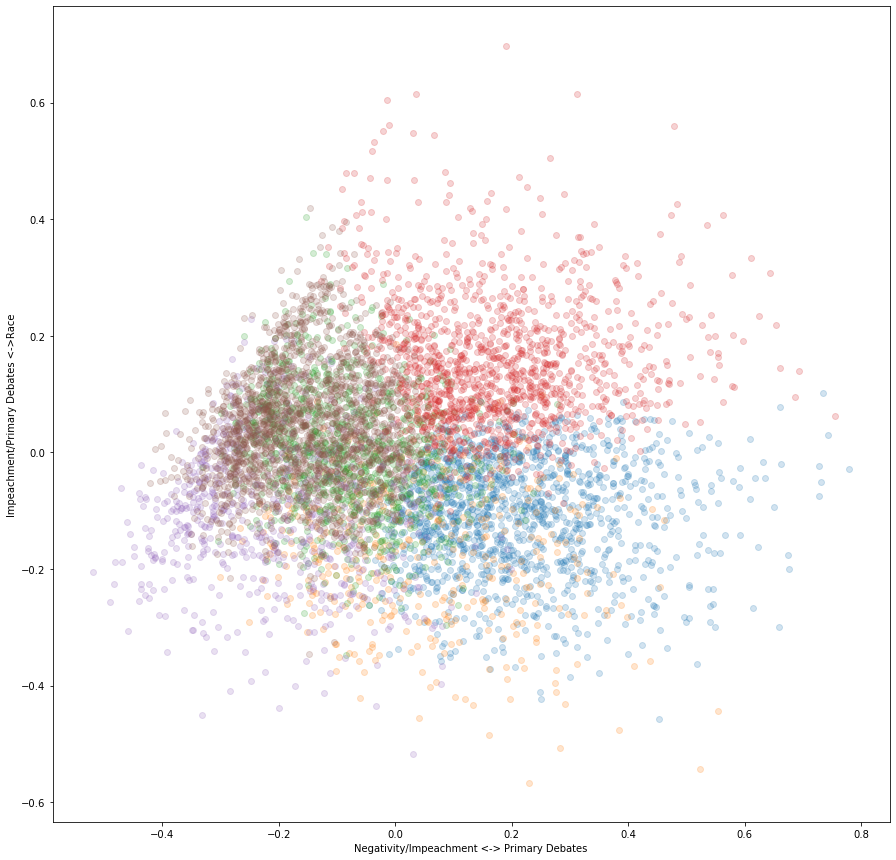

In [484]:
plt.figure(figsize=(15, 15))
for g in range(num_clusters):
    plt.scatter(to_graph[to_graph.group == g][0], to_graph[to_graph.group == g][2], alpha=0.2)
plt.xlabel(pca_labels[0])
plt.ylabel(pca_labels[2])

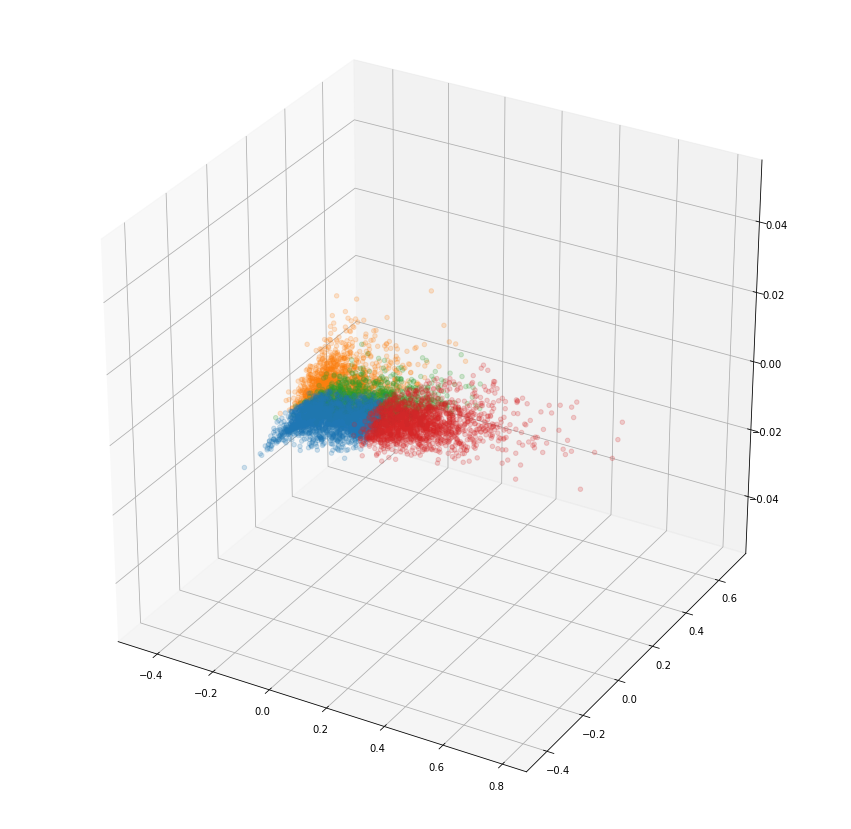

In [695]:
%matplotlib inline

plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
for g in range(num_clusters):
    ax.scatter(pca_graph[pca_graph.group == g][0], pca_graph[pca_graph.group == g][2], alpha=0.2)

### Tsne

In [700]:
from sklearn.manifold import TSNE
from itertools import cycle

In [ ]:
model = TSNE(n_components=2, random_state=0,verbose=0)
low_data = model.fit_transform(cluster_df)

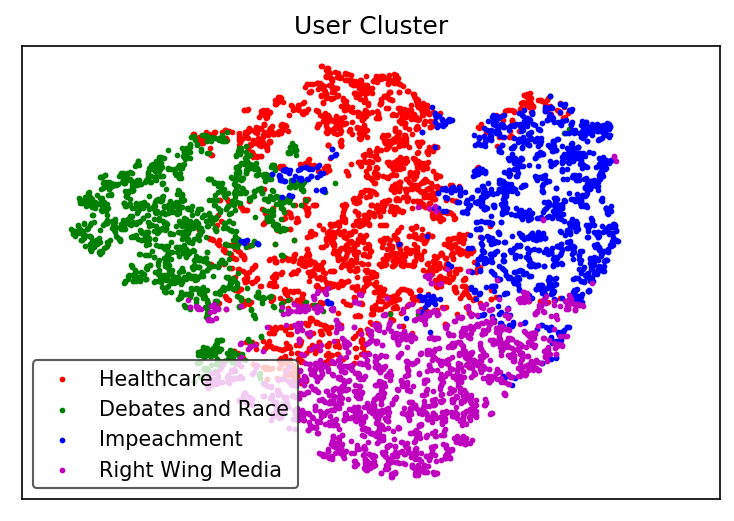

In [717]:
target = interp.group
target_names = ['Healthcare', 'Debates and Race', 'Impeachment', 'Right Wing Media']

colors = cycle(['r','g','b','m','y','orange','k','aqua','yellow'])
target_ids = range(len(target_names))
plt.figure(dpi=150)
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(low_data[target == i, 0], low_data[target == i, 1], c=c, label=label, s=3, alpha=1)
plt.legend(fontsize=10, loc='lower left', frameon=True, facecolor='#FFFFFF', edgecolor='#333333')
plt.xlim(-100,100);
plt.title("User Cluster", fontsize=12)
# plt.ylabel("Junk TSNE Axis 2", fontsize=12)
# plt.xlabel("Junk TSNE Axis 1", fontsize=12);
plt.xticks([])
plt.yticks([]);

### Lookup Correlations

In [677]:
def label_candidate_supporter(row):
    cand_activity = row.loc['perc_comments_warren':'perc_comments_klob']
    if np.max(cand_activity) > 0.5:
        return candidate_activity[np.argmax(cand_activity)].replace('perc_comments_', '')
    elif np.sum(cand_activity) > 0.5:
        return 'undecided'
    else:
        return 'not_considering_candidates'

In [678]:
user_data = no_outliers.reset_index()
interp = pd.concat([user_data, to_graph], axis=1)
interp['candidate_supporter'] = interp.apply(label_candidate_supporter, axis=1)

In [718]:
interp.group.value_counts()

0    2275
3    1812
2    1373
1    1338
Name: group, dtype: int64

In [679]:
# Percent of each group that supports a candidate

by_cand_grp = interp.groupby(['group', 'candidate_supporter']).agg({'author': 'count'})
by_cand = interp.groupby('group').agg({'author': 'count'})
res = by_cand_grp / by_cand
pd.pivot_table(res.reset_index(), index='candidate_supporter', columns='group')

author                  
group                           0     1     2     3
candidate_supporter                                
biden                       0.005 0.062 0.001 0.004
bloomberg                   0.001 0.002   nan   nan
klob                        0.001 0.003   nan   nan
not_considering_candidates  0.141 0.101 0.627 0.086
pete                        0.091 0.499 0.041 0.036
sanders                     0.555 0.266 0.251 0.825
undecided                   0.026 0.022 0.012 0.008
warren                      0.180 0.045 0.068 0.041

In [460]:
# Percent of each candidates supporters by group

by_cand_grp = interp.groupby(['candidate_supporter', 'group']).agg({'group': 'count'})
by_cand = interp.groupby('candidate_supporter').agg({'group': 'count'})
by_cand_grp / by_cand

group
candidate_supporter        group       
biden                      0      0.340
                           1      0.126
                           2      0.165
                           3      0.107
                           4      0.107
                           5      0.087
                           6      0.068
bloomberg                  0      0.500
                           2      0.167
                           3      0.167
                           4      0.167
klob                       0      0.333
                           1      0.167
                           2      0.167
                           3      0.167
                           6      0.167
not_considering_candidates 0      0.340
                           1      0.075
                           2      0.156
                           3      0.129
                           4      0.087
                           5      0.117
                           6      0.096
pete                       0      0.298
                           1      0.083
                           2      0.171
                           3      0.136
                           4      0.092
                           5      0.121
                           6      0.098
sanders                    0      0.316
                           1      0.075
                           2      0.163
                           3      0.143
                           4      0.091
                           5      0.109
                           6      0.103
undecided                  0      0.314
                           1      0.083
                           2      0.165
                           3      0.165
                           4      0.099
                           5      0.116
                           6      0.058
warren                     0      0.270
                           1      0.072
                           2      0.179
                           3      0.138
                           4      0.085
                           5      0.157
                           6      0.097

# Candidate By Tone

In [376]:
for col in tone_global_fields:
    print('******', col, '******')
    print(interp.groupby(['candidate_supporter'])[col].agg('sum') / interp.candidate_supporter.value_counts())

****** all_comments_joy ******
biden                        0.777
bloomberg                    1.000
klob                         0.833
not_considering_candidates   0.752
pete                         0.738
sanders                      0.749
undecided                    0.727
warren                       0.752
dtype: float64
****** all_comments_sadness ******
biden                        0.718
bloomberg                    1.000
klob                         0.667
not_considering_candidates   0.712
pete                         0.697
sanders                      0.713
undecided                    0.744
warren                       0.673
dtype: float64
****** all_comments_tentative ******
biden                        0.709
bloomberg                    1.000
klob                         0.833
not_considering_candidates   0.731
pete                         0.716
sanders                      0.723
undecided                    0.736
warren                       0.706
dtype: float64
****** all_c

In [377]:
for col in tone_sent_fields:
    print('******', col, '******')
    print(interp.groupby(['candidate_supporter'])[col].agg('sum') / interp.candidate_supporter.value_counts())

****** perc_comments_analytical ******
biden                        0.336
bloomberg                    0.299
klob                         0.346
not_considering_candidates   0.328
pete                         0.323
sanders                      0.329
undecided                    0.321
warren                       0.319
dtype: float64
****** perc_comments_joy ******
biden                        0.135
bloomberg                    0.101
klob                         0.123
not_considering_candidates   0.138
pete                         0.136
sanders                      0.138
undecided                    0.137
warren                       0.138
dtype: float64
****** perc_comments_tentative ******
biden                        0.216
bloomberg                    0.277
klob                         0.217
not_considering_candidates   0.225
pete                         0.221
sanders                      0.222
undecided                    0.225
warren                       0.220
dtype: float64
******

In [387]:
for col in ['avg_comment_length', 'num_comments', 'perc_neg_sent_comments', 'perc_neu_sent_comments', 'perc_pos_sent_comments', 'perc_neg_score_comments']:
    print('******', col, '******')
    print(interp.groupby(['candidate_supporter'])[col].agg('mean'))

****** avg_comment_length ******
candidate_supporter
biden                        188.091
bloomberg                    264.492
klob                         173.591
not_considering_candidates   289.895
pete                         224.531
sanders                      196.136
undecided                    273.199
warren                       271.142
Name: avg_comment_length, dtype: float64
****** num_comments ******
candidate_supporter
biden                         80.544
bloomberg                     52.000
klob                          31.667
not_considering_candidates    58.118
pete                         103.063
sanders                       65.521
undecided                     59.810
warren                        66.610
Name: num_comments, dtype: float64
****** perc_neg_sent_comments ******
candidate_supporter
biden                        0.239
bloomberg                    0.206
klob                         0.187
not_considering_candidates   0.371
pete                         0.233


In [388]:
for col in col_to_perc:
    print('******', col, '******')
    print(interp.groupby(['candidate_supporter'])[col].agg('mean'))

****** 2016_election_frustration ******
candidate_supporter
biden                        0.046
bloomberg                    0.080
klob                         0.052
not_considering_candidates   0.092
pete                         0.029
sanders                      0.042
undecided                    0.047
warren                       0.027
Name: 2016_election_frustration, dtype: float64
****** impeachment_proceedings ******
candidate_supporter
biden                        0.005
bloomberg                    0.003
klob                         0.009
not_considering_candidates   0.026
pete                         0.007
sanders                      0.009
undecided                    0.012
warren                       0.010
Name: impeachment_proceedings, dtype: float64
****** healthcare ******
candidate_supporter
biden                        0.011
bloomberg                    0.013
klob                         0.006
not_considering_candidates   0.027
pete                         0.021
sanders 

### Bernie Bros EDA

In [719]:
interp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6798 entries, 0 to 6797
Data columns (total 82 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   level_0                             6798 non-null   int64  
 1   2016_election_frustration           6798 non-null   float64
 2   impeachment_proceedings             6798 non-null   float64
 3   healthcare                          6798 non-null   float64
 4   primary_candidates                  6798 non-null   float64
 5   gun_control                         6798 non-null   float64
 6   election_general_terms              6798 non-null   float64
 7   right_wing_media                    6798 non-null   float64
 8   impeachment                         6798 non-null   float64
 9   yang_ubi                            6798 non-null   float64
 10  primary_debates                     6798 non-null   float64
 11  bloomberg                           6798 no

In [ ]:
# Anger

In [721]:
interp[interp.candidate_supporter == 'sanders'].perc_comments_anger.mean()

0.049041512489177895

In [723]:
interp[interp.candidate_supporter != 'sanders'].perc_comments_anger.mean()

0.050709956338472785

In [724]:
# negative

In [729]:
interp[interp.candidate_supporter == 'sanders'].perc_neg_sent_comments.iloc[:, 0].mean()

0.26614282397557215

In [730]:
interp[interp.candidate_supporter != 'sanders'].perc_neg_sent_comments.iloc[:, 0].mean()

0.3029920831583057

In [ ]:
# anger - overall

In [731]:
interp[interp.candidate_supporter == 'sanders'].all_comments_anger.mean()

0.3083598495805612

In [733]:
interp[interp.candidate_supporter != 'sanders'].all_comments_anger.mean()

0.30170607602514216

In [734]:
# top 10% in negativity

In [737]:
interp.perc_neg_sent_comments.iloc[:, 0].describe([.9])

count   6798.000
mean       0.284
std        0.119
min        0.000
50%        0.275
90%        0.441
max        0.948
Name: perc_neg_sent_comments, dtype: float64

In [740]:
interp[interp.perc_neg_sent_comments.iloc[:, 0] > 0.441].candidate_supporter.value_counts() / interp[interp.perc_neg_sent_comments.iloc[:, 0] > 0.441].shape[0]

not_considering_candidates   0.539
sanders                      0.365
warren                       0.060
pete                         0.031
undecided                    0.004
biden                        0.001
Name: candidate_supporter, dtype: float64

In [742]:
interp.candidate_supporter.value_counts() / interp.shape[0]

sanders                      0.509
not_considering_candidates   0.217
pete                         0.147
warren                       0.094
undecided                    0.018
biden                        0.015
klob                         0.001
bloomberg                    0.001
Name: candidate_supporter, dtype: float64

In [ ]:
# top ten percent in anger

In [744]:
interp.all_comments_anger.describe([.9])

count   6798.000
mean       0.305
std        0.460
min        0.000
50%        0.000
90%        1.000
max        1.000
Name: all_comments_anger, dtype: float64

In [747]:
interp[interp.all_comments_anger == 1].candidate_supporter.value_counts() / interp[interp.all_comments_anger == 1].shape[0]

sanders                      0.514
not_considering_candidates   0.206
pete                         0.150
warren                       0.091
undecided                    0.020
biden                        0.017
bloomberg                    0.001
klob                         0.001
Name: candidate_supporter, dtype: float64

In [748]:
interp[interp.all_comments_anger != 1].candidate_supporter.value_counts() / interp[interp.all_comments_anger != 1].shape[0]


sanders                      0.506
not_considering_candidates   0.221
pete                         0.145
warren                       0.095
undecided                    0.017
biden                        0.014
bloomberg                    0.001
klob                         0.001
Name: candidate_supporter, dtype: float64